# 異常検知通し課題Day5

In [158]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

# 本Notebookの目的


- 東京都内の降雪日を異常と定義した
- 都内での降雪日への変化点を事前に検知することで、交通機関の乱れを予測し、稼働管理の一助になることを目指す
- 第一に慣れしたんだ通常の機械学習モデルを利用することで、重要な説明変数を発見し、気象データそのものにも慣れる
- 第二に外れ値検出モデルを利用し、異常検知に慣れる
- 第三に降雪を変化点検知モデルを用いて事前に予測する

### Day1の目的
- 軽量に気象データをあつかってみる....⇒Day２以降に本格的に取り組むための全体の理解
    - 統計量の算出
    - グラフ化
    - 簡単な前処理
    - 基本的な機械学習で異常検知ができるのTry
    - ランダムフォレストでの説明変数の重要度を確認
    - ネイマン・ピアソン決定則
    - 反省：異常検知のアルゴリズムを扱いきれていない、異常検知特有の全体フローをわかってない

### Day2の目的
- 3年⇒30年分の気象データを扱いNotebookの手法を簡易に扱う
    - 統計量の算出
    - グラフ化
    - 前処理
    - 1次元正規分布に基づく外れ値検出
    - 混合ガウス分布による外れ値検出
    - ARモデルによる変化検知
    - 反省：GMMには、異常と正常データを分離する。ARモデルはコレログラムを用いてMaxlagを設定する

### Day3の目的
- 前回指摘事項の改善
 - GMM：正常及び異常データで学習→正常のみのデータで学習
 - AR：コレログラムを作成し、MaxLagのハイパーパラメータを決定
 - 反省GMM：うまくNotebookにあるところまでできたが、これから閾値を決めるほうが良いか？決めたあとどのようにグラフに反映すべきか？？
 - 反省ARモデル：コレログラムは作成できたが、そもそもどのようにこのLagsの値を入れてよいかわからない。さらにこのコレログラムからMaxlagを決めてよいかご教示してほしいです。

### Day4（Ver1,Ver2）の目的
- ARモデルを利用する前に偏相関係数を利用する。
- 偏相関係数のコレログラムを利用して、ARモデルのMaxlagのハイパーパラメータを利用する
- 近傍法による変化点検知
- 部分空間法による変化点検知
- コメント欄の整理
- 指摘事項の反映
  - ARモデルmax lagの設定の変更
  - 部分空間法の窓枠（ｗ）変更

### Day5の目的
- 東京都内30年分の1月から12月データ→東京都内12月、1月、2月のデータに削減

### 必要なライブラリのインストール

In [119]:
##基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import japanize_matplotlib#Matplotlibの日本語対応
import seaborn as sns
import scipy
import scipy.stats as stats
import copy

#機械学習用
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#異常検知用
#外れ値検出
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

#変化点検知
import statsmodels.api as sm #ARMAで予測する際に用いるライブラリ
import changefinder
import numpy.linalg as LA#部分空間法
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, roc_auc_score, roc_curve

### Dataの簡易分析

In [120]:
df = pd.read_csv("ad_tokyo_winter_30y.csv")

In [121]:
df.shape

(2853, 30)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 30 columns):
年月日                  2853 non-null object
年                    2853 non-null int64
月                    2853 non-null int64
平均気温(℃)              2853 non-null float64
最高気温(℃)              2853 non-null float64
最低気温(℃)              2853 non-null float64
降水量の合計(mm)           2853 non-null float64
降水量の合計(mm)：現象有無      2853 non-null int64
日照時間(時間)             2853 non-null float64
日照時間(時間)：現象有無        2853 non-null int64
合計全天日射量(MJ/㎡)        2853 non-null float64
最深積雪(cm)             2853 non-null int64
最深積雪(cm)：現象有無        2853 non-null int64
降雪量合計(cm)            2853 non-null int64
降雪量合計(cm)：現象有無       2853 non-null int64
平均風速(m/s)            2845 non-null float64
最大風速(m/s)            2853 non-null float64
最大風速(m/s)：風向き        2853 non-null object
最大瞬間風速(m/s)          2853 non-null float64
最大瞬間風速(m/s)：風向き      2853 non-null object
最多風向(16方位)           2853 non-null object
平均蒸気圧(hPa)

In [123]:
for x in df.columns:
    print(x)

年月日
年
月
平均気温(℃)
最高気温(℃)
最低気温(℃)
降水量の合計(mm)
降水量の合計(mm)：現象有無
日照時間(時間)
日照時間(時間)：現象有無
合計全天日射量(MJ/㎡)
最深積雪(cm)
最深積雪(cm)：現象有無
降雪量合計(cm)
降雪量合計(cm)：現象有無
平均風速(m/s)
最大風速(m/s)
最大風速(m/s)：風向き
最大瞬間風速(m/s)
最大瞬間風速(m/s)：風向き
最多風向(16方位)
平均蒸気圧(hPa)
平均湿度(％)
最小相対湿度(％)
最低海面気圧(hPa)
平均海面気圧(hPa)
平均現地気圧(hPa)
平均雲量(10分比)
天気概況(夜：18時～翌日06時)
天気概況(昼：06時～18時)


In [124]:
df.head(3)

,年月日,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,...,最多風向(16方位),平均蒸気圧(hPa),平均湿度(％),最小相対湿度(％),最低海面気圧(hPa),平均海面気圧(hPa),平均現地気圧(hPa),平均雲量(10分比),天気概況(夜：18時～翌日06時),天気概況(昼：06時～18時)
0,1987/12/1,1987,12,5.0,6.8,3.0,5.5,0,0.0,1,...,0,7.2,81,53.0,0.0,1011.0,1006.5,10.0,降水なし,曇時々雨
1,1987/12/2,1987,12,6.3,9.8,3.7,0.0,1,9.5,0,...,0,3.9,43,21.0,0.0,1008.1,1003.7,0.5,降水なし,晴
2,1987/12/3,1987,12,6.3,10.3,1.5,0.0,1,9.3,0,...,0,5.0,53,35.0,0.0,1015.3,1010.9,0.0,降水なし,晴


In [125]:
df.isnull().sum()

年月日                  0
年                    0
月                    0
平均気温(℃)              0
最高気温(℃)              0
最低気温(℃)              0
降水量の合計(mm)           0
降水量の合計(mm)：現象有無      0
日照時間(時間)             0
日照時間(時間)：現象有無        0
合計全天日射量(MJ/㎡)        0
最深積雪(cm)             0
最深積雪(cm)：現象有無        0
降雪量合計(cm)            0
降雪量合計(cm)：現象有無       0
平均風速(m/s)            8
最大風速(m/s)            0
最大風速(m/s)：風向き        0
最大瞬間風速(m/s)          0
最大瞬間風速(m/s)：風向き      0
最多風向(16方位)           0
平均蒸気圧(hPa)           0
平均湿度(％)              0
最小相対湿度(％)            1
最低海面気圧(hPa)          0
平均海面気圧(hPa)          0
平均現地気圧(hPa)          0
平均雲量(10分比)           0
天気概況(夜：18時～翌日06時)    0
天気概況(昼：06時～18時)      0
dtype: int64

In [126]:
for feature in df.columns:
    print(feature+':\n'+str(df[feature].unique())+':\n' )

年月日:
['1987/12/1' '1987/12/2' '1987/12/3' ... '2018/12/22' '2018/12/23'
 '2018/12/24']:

年:
[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018]:

月:
[12  1  2  3]:

平均気温(℃):
[ 5.   6.3  6.5  5.8  2.9  4.5  5.3  8.  11.7 11.1  8.6  3.   8.2  9.4
  7.4  5.6  6.9  7.8  9.7 10.4 11.3 13.5 12.1 12.  11.5 10.3  7.1  8.9
  8.7  9.1  5.9  3.5  8.1  4.8  9.  10.5  9.9  7.2  5.7  6.1  7.3  6.7
 11.8  6.8  7.6  7.5  6.   2.4 10.9  4.3  4.   5.1  3.2  5.2  3.3  2.2
  2.7  3.9  6.4  3.8  3.6  2.6  5.4  9.3  8.4 10.  11.6  8.5 10.2  9.6
  8.8  7.   6.6  7.9  9.8  4.4 14.6 11.   8.3  9.2 10.7  7.7  5.5 13.6
  6.2  4.2 13.2 12.2 13.8 13.3 12.9 10.1 10.6  1.3  3.4  4.9  3.7  2.3
  1.5  1.   2.8 12.4 13.  14.1 19.7 15.9 11.9 10.8 12.3 11.4  4.6  4.1
 12.7 12.5 12.6 12.8  9.5  4.7 14.9 17.2 14.  14.3 16.5 11.2 15.2 14.4
  2.5  0.9  2.  16.1  0.7  1.2 13.4  1.7  1.4 13.9  1.8  3.1  2.1  0.5
 15.

In [127]:
df.describe()

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),...,平均風速(m/s),最大風速(m/s),最大瞬間風速(m/s),平均蒸気圧(hPa),平均湿度(％),最小相対湿度(％),最低海面気圧(hPa),平均海面気圧(hPa),平均現地気圧(hPa),平均雲量(10分比)
count,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,2853.000000,...,2845.000000,2853.000000,2853.000000,2853.000000,2853.000000,2852.000000,2853.000000,2853.000000,2853.000000,2853.000000
mean,2002.786540,5.126533,7.204627,11.111006,3.612864,2.038906,0.626709,5.919103,0.083421,9.401535,...,3.203234,6.399264,11.897266,5.213284,50.362075,33.238429,591.586505,1016.372485,1012.133929,4.774238
std,9.030706,5.010624,2.633784,3.181329,2.571183,7.444928,0.483763,3.477559,0.276566,4.091730,...,1.095626,2.033272,4.508671,2.014482,14.696902,13.398276,498.756195,6.949406,6.933163,3.431950
min,1987.000000,1.000000,0.000000,1.500000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.300000,...,1.300000,2.700000,3.800000,1.700000,22.000000,6.000000,0.000000,982.600000,978.400000,0.000000
25%,1995.000000,1.000000,5.400000,9.100000,1.800000,0.000000,0.000000,2.700000,0.000000,6.820000,...,2.400000,4.800000,8.400000,3.700000,39.000000,23.000000,0.000000,1011.900000,1007.700000,1.800000
50%,2003.000000,2.000000,6.900000,10.800000,3.300000,0.000000,1.000000,7.300000,0.000000,10.100000,...,3.000000,6.000000,11.000000,4.900000,48.000000,30.000000,1003.200000,1016.800000,1012.500000,4.500000
75%,2011.000000,12.000000,8.800000,13.000000,5.200000,0.000000,1.000000,8.900000,0.000000,11.900000,...,3.800000,7.600000,14.600000,6.300000,59.000000,40.000000,1014.000000,1021.300000,1017.000000,7.800000
max,2018.000000,12.000000,19.700000,24.800000,17.000000,154.500000,1.000000,10.900000,1.000000,19.620000,...,8.500000,17.500000,40.200000,16.400000,95.000000,89.000000,1031.700000,1035.300000,1030.900000,10.000000


In [128]:
#各特徴量の相関係数の可視化:
df.corr().style.background_gradient().format("{:.2f}")

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),最深積雪(cm),最深積雪(cm)：現象有無,降雪量合計(cm),降雪量合計(cm)：現象有無,平均風速(m/s),最大風速(m/s),最大瞬間風速(m/s),平均蒸気圧(hPa),平均湿度(％),最小相対湿度(％),最低海面気圧(hPa),平均海面気圧(hPa),平均現地気圧(hPa),平均雲量(10分比)
年,1.00,-0.03,-0.10,-0.03,-0.13,0.03,0.01,0.02,-0.17,0.13,0.03,-0.02,0.01,0.12,-0.25,-0.16,-0.11,-0.05,-0.00,-0.05,0.85,-0.03,0.00,0.03
月,-0.03,1.00,0.40,0.31,0.42,-0.02,0.03,-0.05,-0.03,-0.24,-0.08,0.11,-0.05,0.11,-0.13,-0.12,-0.11,0.27,0.10,0.13,0.01,0.06,0.06,-0.05
平均気温(℃),-0.10,0.40,1.00,0.92,0.87,-0.02,-0.06,-0.00,-0.09,-0.06,-0.20,0.28,-0.17,0.29,-0.11,-0.03,-0.00,0.67,0.18,0.17,-0.06,-0.11,-0.11,0.05
最高気温(℃),-0.03,0.31,0.92,1.00,0.65,-0.05,0.06,0.21,-0.21,0.14,-0.18,0.26,-0.16,0.29,-0.11,0.04,0.07,0.55,0.08,-0.00,-0.03,-0.19,-0.18,-0.13
最低気温(℃),-0.13,0.42,0.87,0.65,1.00,0.07,-0.23,-0.26,0.09,-0.30,-0.17,0.24,-0.12,0.19,-0.01,-0.02,-0.01,0.69,0.30,0.34,-0.05,-0.06,-0.06,0.27
降水量の合計(mm),0.03,-0.02,-0.02,-0.05,0.07,1.00,-0.35,-0.37,0.35,-0.39,0.22,-0.21,0.30,-0.23,0.13,0.13,0.13,0.34,0.47,0.39,0.04,-0.17,-0.17,0.33
降水量の合計(mm)：現象有無,0.01,0.03,-0.06,0.06,-0.23,-0.35,1.00,0.63,-0.36,0.56,-0.09,0.15,-0.11,0.28,-0.02,-0.03,-0.02,-0.48,-0.60,-0.53,0.01,0.16,0.16,-0.62
日照時間(時間),0.02,-0.05,-0.00,0.21,-0.26,-0.37,0.63,1.00,-0.51,0.89,-0.07,0.13,-0.13,0.23,0.11,0.16,0.16,-0.50,-0.67,-0.70,-0.00,0.03,0.03,-0.85
日照時間(時間)：現象有無,-0.17,-0.03,-0.09,-0.21,0.09,0.35,-0.36,-0.51,1.00,-0.54,0.06,-0.14,0.12,-0.24,0.10,0.01,-0.01,0.28,0.45,0.45,-0.10,0.00,-0.00,0.42
合計全天日射量(MJ/㎡),0.13,-0.24,-0.06,0.14,-0.30,-0.39,0.56,0.89,-0.54,1.00,-0.06,0.11,-0.14,0.22,0.15,0.19,0.19,-0.54,-0.69,-0.72,0.09,0.05,0.06,-0.68


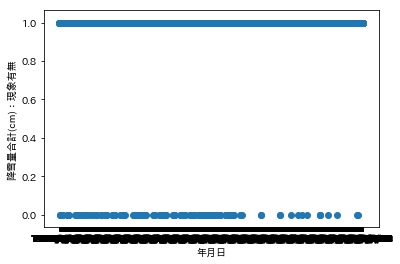

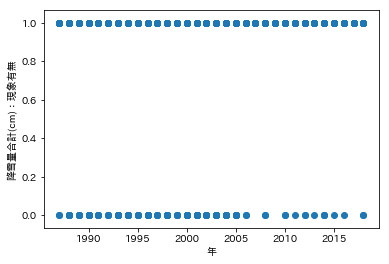

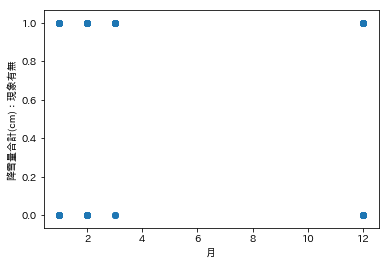

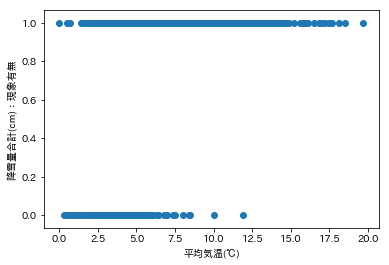

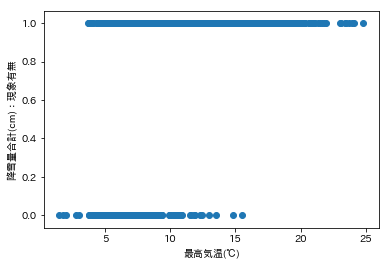

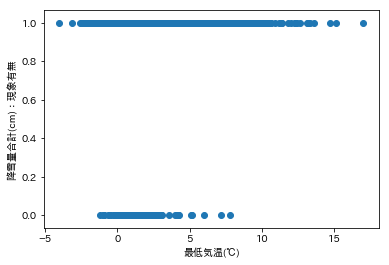

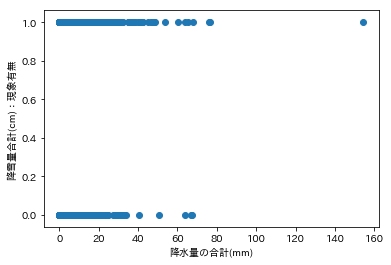

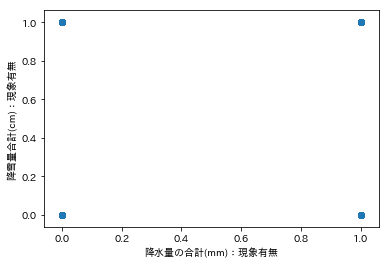

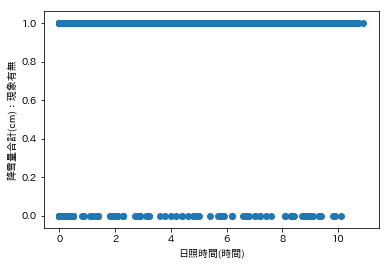

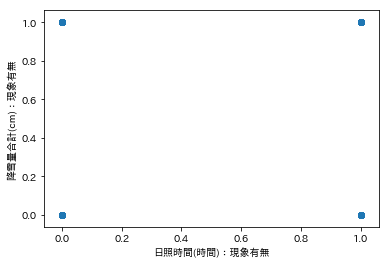

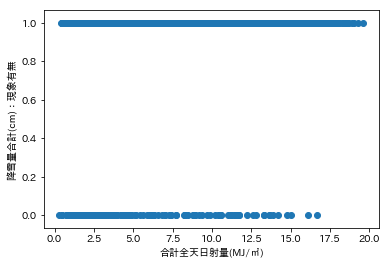

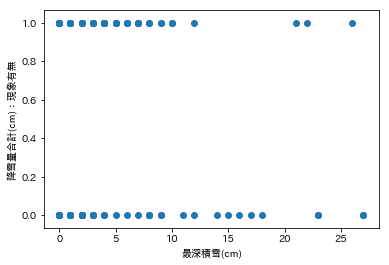

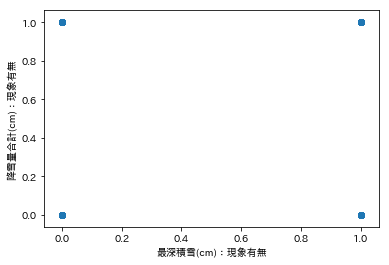

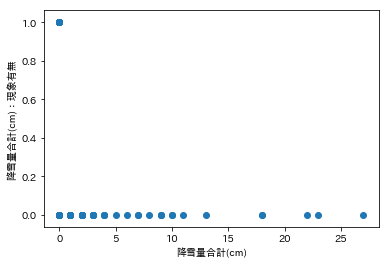

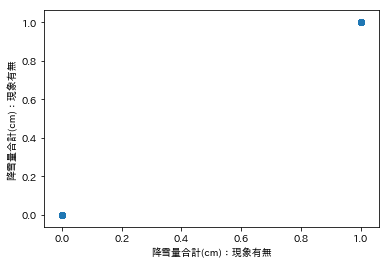

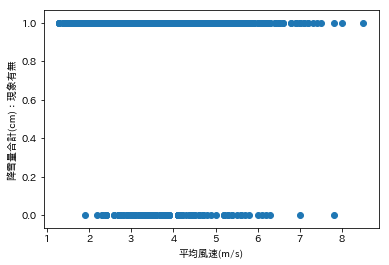

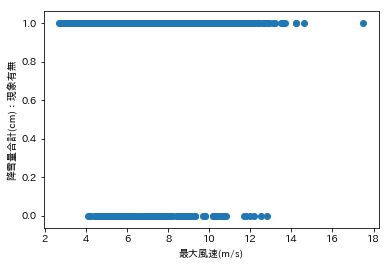

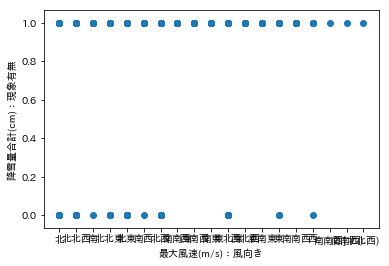

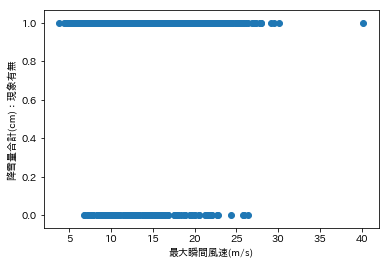

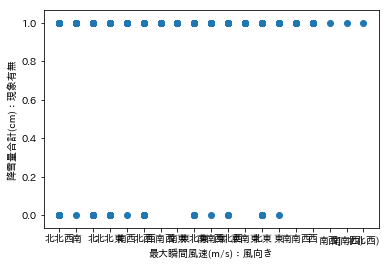

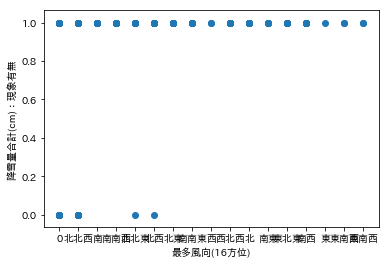

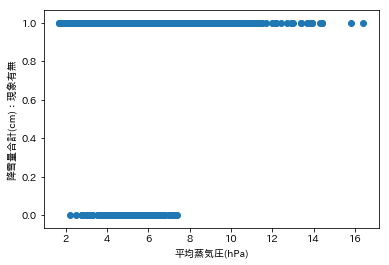

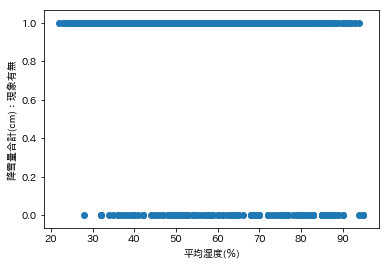

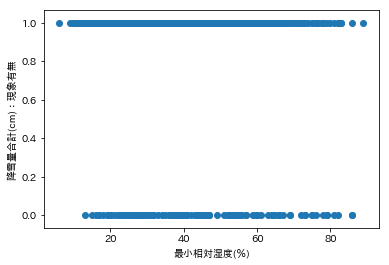

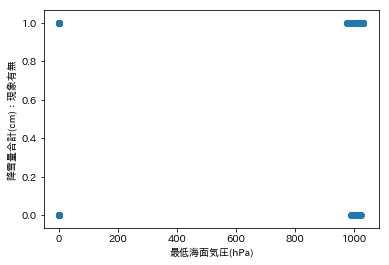

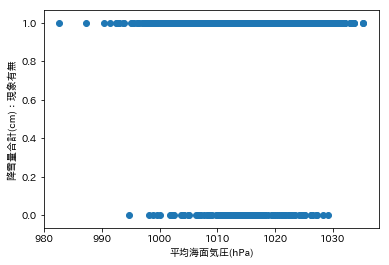

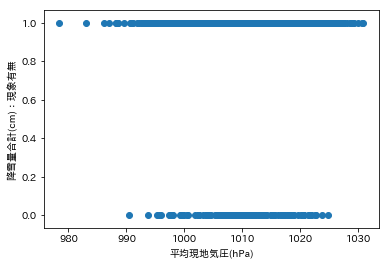

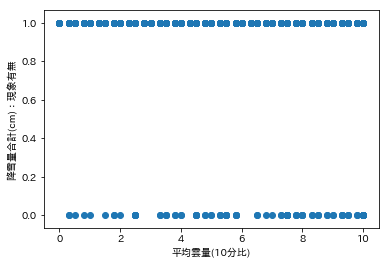

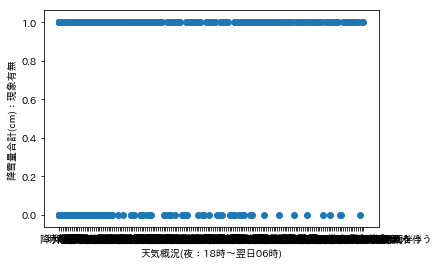

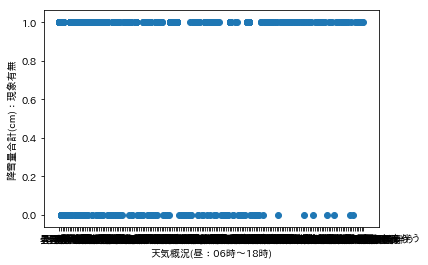

In [129]:
for column in df.columns:
    plt.scatter(df[column], df['降雪量合計(cm)：現象有無'])
    plt.xlabel(column)
    plt.ylabel('降雪量合計(cm)：現象有無')
    plt.show()

In [132]:
df['降雪量合計(cm)：現象有無'].value_counts()

1    2703
0     150
Name: 降雪量合計(cm)：現象有無, dtype: int64

Text(0.5, 1.0, '降雪量合計(cm): 現象有無における降雪数量')

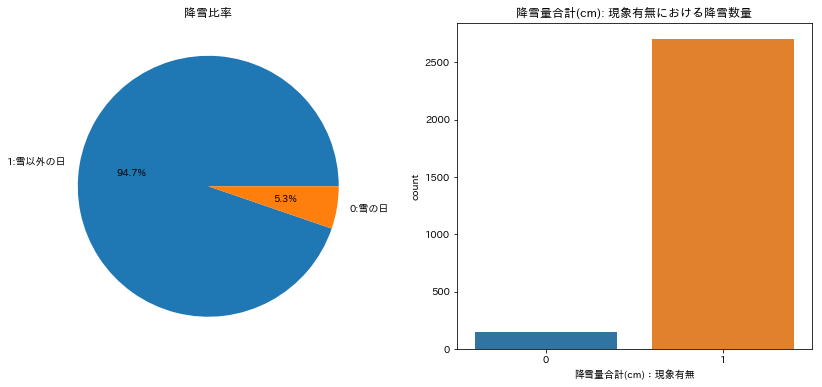

In [133]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].pie(df["降雪量合計(cm)：現象有無"].value_counts(),labels=["1:雪以外の日","0:雪の日"] , autopct='%.1f%%' )
ax[0].set_title("降雪比率")
sns.countplot(df["降雪量合計(cm)：現象有無"],ax=ax[1])
ax[1].set_title("降雪量合計(cm): 現象有無における降雪数量")

## 前処理

In [134]:
#名寄せ

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 30 columns):
年月日                  2853 non-null object
年                    2853 non-null int64
月                    2853 non-null int64
平均気温(℃)              2853 non-null float64
最高気温(℃)              2853 non-null float64
最低気温(℃)              2853 non-null float64
降水量の合計(mm)           2853 non-null float64
降水量の合計(mm)：現象有無      2853 non-null int64
日照時間(時間)             2853 non-null float64
日照時間(時間)：現象有無        2853 non-null int64
合計全天日射量(MJ/㎡)        2853 non-null float64
最深積雪(cm)             2853 non-null int64
最深積雪(cm)：現象有無        2853 non-null int64
降雪量合計(cm)            2853 non-null int64
降雪量合計(cm)：現象有無       2853 non-null int64
平均風速(m/s)            2845 non-null float64
最大風速(m/s)            2853 non-null float64
最大風速(m/s)：風向き        2853 non-null object
最大瞬間風速(m/s)          2853 non-null float64
最大瞬間風速(m/s)：風向き      2853 non-null object
最多風向(16方位)           2853 non-null object
平均蒸気圧(hPa)

In [136]:
print(df['最大風速(m/s)：風向き'].value_counts())
print()
print(df['最大瞬間風速(m/s)：風向き'].value_counts())
print()
print(df['最多風向(16方位)'].value_counts())

北北西     1196
北西       529
北        313
南西       152
南        122
北北東      102
北東        79
東北東       72
西北西       68
南南西       53
南南東       47
南東        38
東         33
東南東       24
西南西       16
西          6
南南西]       1
北北西)       1
南南西)       1
Name: 最大風速(m/s)：風向き, dtype: int64

北北西     1005
北西       620
北        347
南西       158
西北西      138
北北東       89
南         88
北東        70
東北東       66
南南西       64
南南東       51
西南西       44
東         40
南東        29
東南東       22
西         19
北北西)       1
南南西)       1
南西]        1
Name: 最大瞬間風速(m/s)：風向き, dtype: int64

0      1918
北北西     492
北西      219
北北東      45
南南西      34
北東       30
西北西      25
南        24
北        22
南南東      15
東北東       9
南西        8
南東        5
西南西       2
西         2
東南東       2
東         1
Name: 最多風向(16方位), dtype: int64


In [137]:
df.loc[df['最大風速(m/s)：風向き'] == '北北西)', '最大風速(m/s)：風向き'] = '北北西'
df.loc[df['最大風速(m/s)：風向き'] == '南南西]', '最大風速(m/s)：風向き'] = '南南西'
df.loc[df['最大風速(m/s)：風向き'] == '南南西)', '最大風速(m/s)：風向き'] = '南南西'

In [138]:
df.loc[df['最大瞬間風速(m/s)：風向き'] == '北北西)', '最大瞬間風速(m/s)：風向き'] = '北北西'
df.loc[df['最大瞬間風速(m/s)：風向き'] == '南南西)', '最大瞬間風速(m/s)：風向き'] = '南南西'
df.loc[df['最大瞬間風速(m/s)：風向き'] == '南西]', '最大瞬間風速(m/s)：風向き'] = '南西'

In [139]:
print(df['最大風速(m/s)：風向き'].value_counts())
print()
print(df['最大瞬間風速(m/s)：風向き'].value_counts())

北北西    1197
北西      529
北       313
南西      152
南       122
北北東     102
北東       79
東北東      72
西北西      68
南南西      55
南南東      47
南東       38
東        33
東南東      24
西南西      16
西         6
Name: 最大風速(m/s)：風向き, dtype: int64

北北西    1006
北西      620
北       347
南西      159
西北西     138
北北東      89
南        88
北東       70
東北東      66
南南西      65
南南東      51
西南西      44
東        40
南東       29
東南東      22
西        19
Name: 最大瞬間風速(m/s)：風向き, dtype: int64


In [140]:
#欠損値の処理

In [141]:
df.isnull().sum()

年月日                  0
年                    0
月                    0
平均気温(℃)              0
最高気温(℃)              0
最低気温(℃)              0
降水量の合計(mm)           0
降水量の合計(mm)：現象有無      0
日照時間(時間)             0
日照時間(時間)：現象有無        0
合計全天日射量(MJ/㎡)        0
最深積雪(cm)             0
最深積雪(cm)：現象有無        0
降雪量合計(cm)            0
降雪量合計(cm)：現象有無       0
平均風速(m/s)            8
最大風速(m/s)            0
最大風速(m/s)：風向き        0
最大瞬間風速(m/s)          0
最大瞬間風速(m/s)：風向き      0
最多風向(16方位)           0
平均蒸気圧(hPa)           0
平均湿度(％)              0
最小相対湿度(％)            1
最低海面気圧(hPa)          0
平均海面気圧(hPa)          0
平均現地気圧(hPa)          0
平均雲量(10分比)           0
天気概況(夜：18時～翌日06時)    0
天気概況(昼：06時～18時)      0
dtype: int64

In [142]:
df["平均風速(m/s)"].fillna(df["平均風速(m/s)"].mean(), inplace=True)
df["最小相対湿度(％)"].fillna(df["最小相対湿度(％)"].mean(),inplace = True)

In [143]:
#カテゴリカル変数の処理

In [144]:
df= pd.concat([df, pd.get_dummies(df["最大風速(m/s)：風向き"])], axis = 1)
df= pd.concat([df,pd.get_dummies(df["最大瞬間風速(m/s)：風向き"])], axis = 1)
df= pd.concat([df, pd.get_dummies(df["最多風向(16方位)"])], axis = 1)

In [145]:
df = df.drop("年月日", axis = 1)
df = df.drop("天気概況(昼：06時～18時)", axis = 1)
df = df.drop("天気概況(夜：18時～翌日06時)", axis = 1)
df = df.drop("最多風向(16方位)", axis = 1)
df = df.drop("最大風速(m/s)：風向き", axis = 1)
df = df.drop("最大瞬間風速(m/s)：風向き", axis = 1)

In [146]:
df.shape

(2853, 73)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 73 columns):
年                  2853 non-null int64
月                  2853 non-null int64
平均気温(℃)            2853 non-null float64
最高気温(℃)            2853 non-null float64
最低気温(℃)            2853 non-null float64
降水量の合計(mm)         2853 non-null float64
降水量の合計(mm)：現象有無    2853 non-null int64
日照時間(時間)           2853 non-null float64
日照時間(時間)：現象有無      2853 non-null int64
合計全天日射量(MJ/㎡)      2853 non-null float64
最深積雪(cm)           2853 non-null int64
最深積雪(cm)：現象有無      2853 non-null int64
降雪量合計(cm)          2853 non-null int64
降雪量合計(cm)：現象有無     2853 non-null int64
平均風速(m/s)          2853 non-null float64
最大風速(m/s)          2853 non-null float64
最大瞬間風速(m/s)        2853 non-null float64
平均蒸気圧(hPa)         2853 non-null float64
平均湿度(％)            2853 non-null int64
最小相対湿度(％)          2853 non-null float64
最低海面気圧(hPa)        2853 non-null float64
平均海面気圧(hPa)        2853 non-null float64
平均現地気圧(hP

In [148]:
#最終的に過年度のデータ量を足すことを考え残しておく
# print(df['日照時間(時間)：現象有無'].value_counts())
# print()
# print(df['最低海面気圧(hPa)'].value_counts())

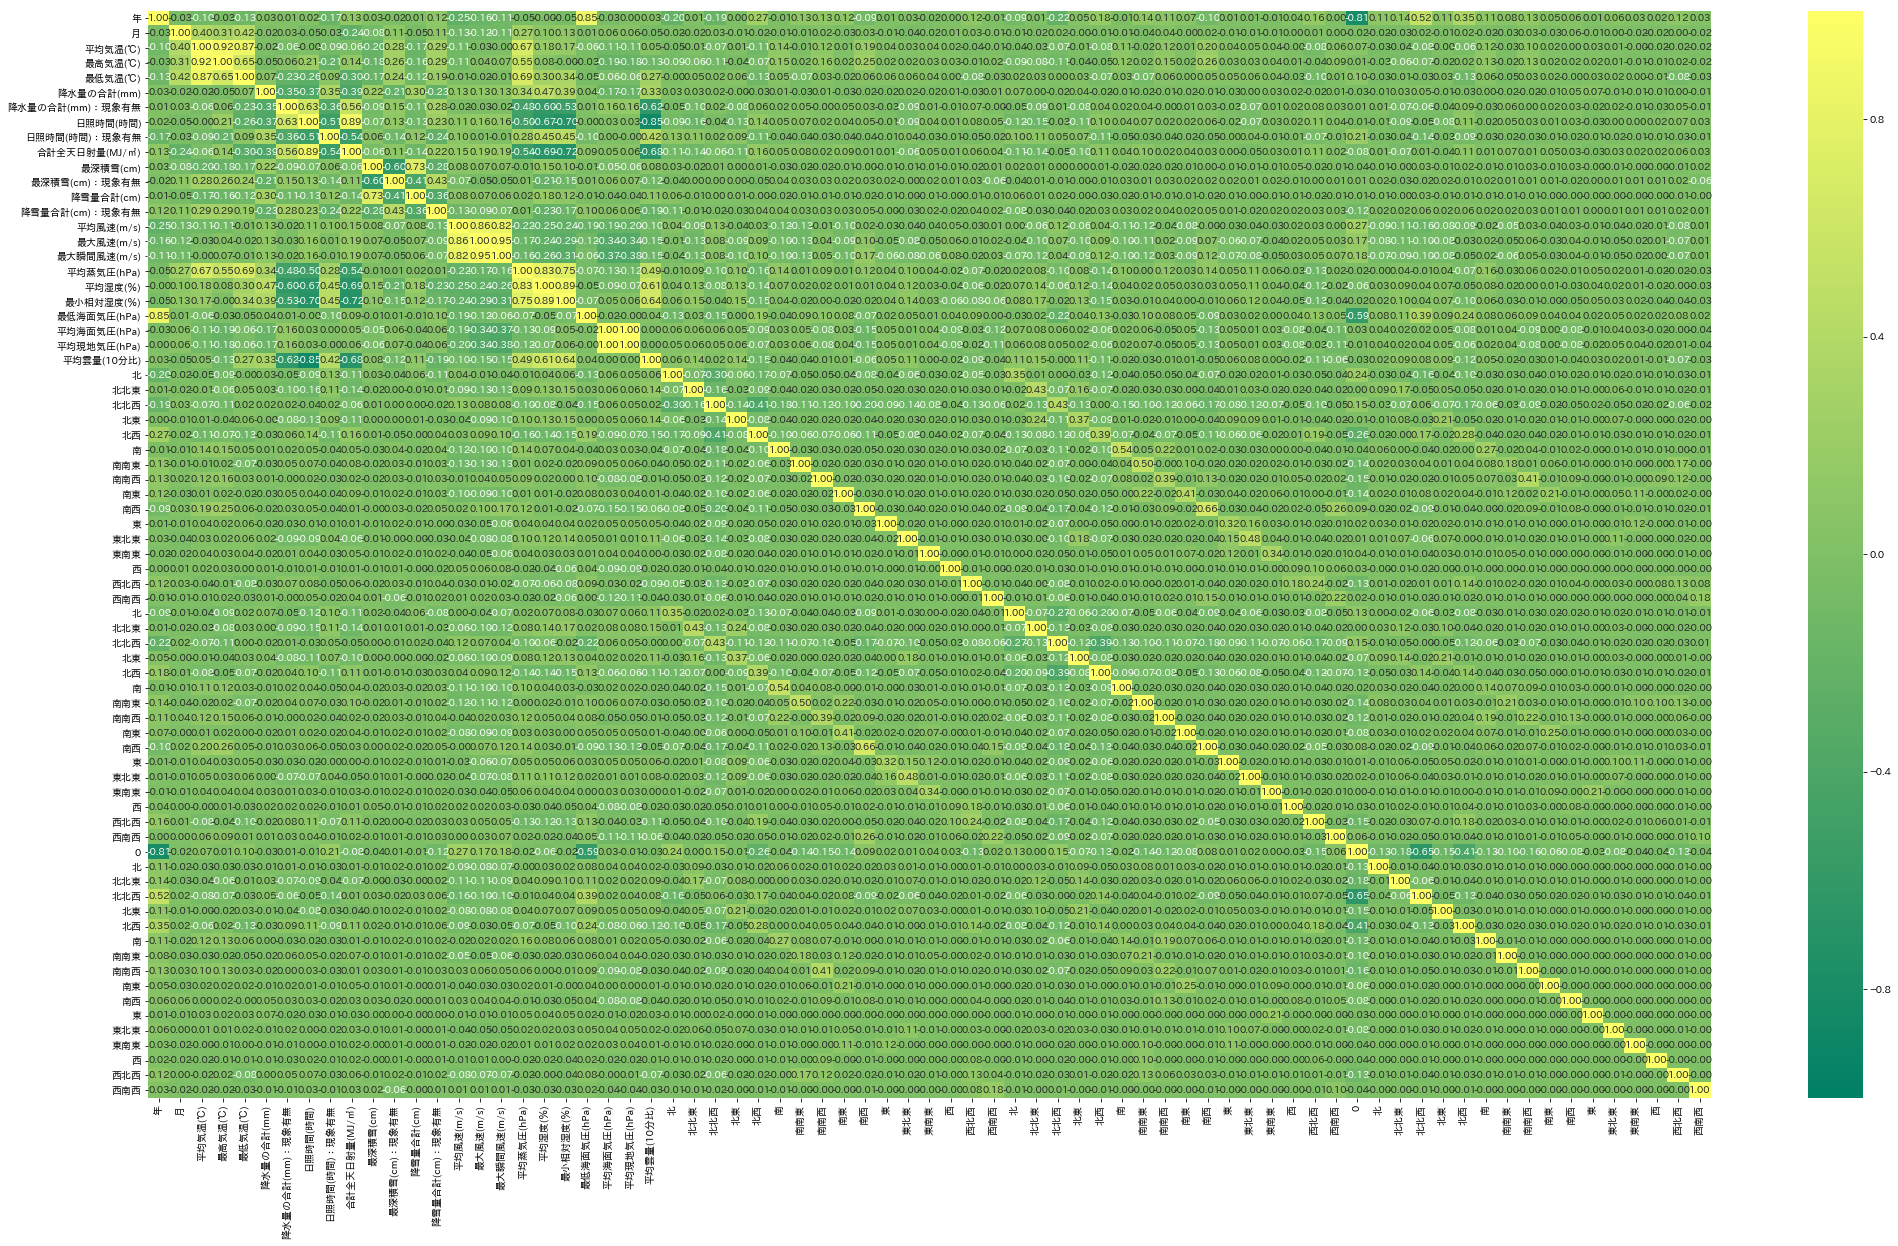

In [149]:
f,ax=plt.subplots(figsize=(35,20))
sns.heatmap(df.corr(),cmap="summer",annot=True,fmt='.2f',vmax=1.0,vmin=-1.0)

In [150]:
###降雪量合計(cm): 現象有無の0に雪が降っていると考えられるが、この行を抽出

In [151]:
#雪の日のみの行を抽出
df[df['降雪量合計(cm)：現象有無'].isin(["0"])]

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),...,南南東,南南西,南東,南西,東,東北東,東南東,西,西北西,西南西
5,1987,12,2.9,5.2,0.9,17.5,0,0.0,1,1.80,...,0,0,0,0,0,0,0,0,0,0
12,1987,12,3.0,7.9,1.0,29.5,0,0.0,1,0.50,...,0,0,0,0,0,0,0,0,0,0
36,1988,1,4.5,7.9,1.0,3.5,0,7.0,0,9.70,...,0,0,0,0,0,0,0,0,0,0
73,1988,2,3.2,5.2,0.4,2.5,0,1.3,0,5.40,...,0,0,0,0,0,0,0,0,0,0
79,1988,2,2.7,6.6,-1.2,0.0,0,7.2,0,12.80,...,0,0,0,0,0,0,0,0,0,0
80,1988,2,3.9,7.6,-0.9,0.0,1,10.1,0,16.10,...,0,0,0,0,0,0,0,0,0,0
86,1988,2,3.2,5.4,2.0,1.5,0,0.0,1,1.90,...,0,0,0,0,0,0,0,0,0,0
88,1988,2,2.6,5.0,1.2,13.5,0,0.0,1,2.90,...,0,0,0,0,0,0,0,0,0,0
148,1989,1,5.7,7.8,3.6,1.0,0,0.3,0,3.60,...,0,0,0,0,0,0,0,0,0,0
166,1989,2,6.0,9.4,4.2,0.0,0,6.2,0,11.70,...,0,0,0,0,0,0,0,0,0,0


### データの分割

In [152]:
y = df['降雪量合計(cm)：現象有無']
df1 = df.copy()
df1.drop('降雪量合計(cm)：現象有無',axis=1,inplace=True)

In [153]:
X=df1
X.head(2)

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),...,南南東,南南西,南東,南西,東,東北東,東南東,西,西北西,西南西
0,1987,12,5.0,6.8,3.0,5.5,0,0.0,1,1.7,...,0,0,0,0,0,0,0,0,0,0
1,1987,12,6.3,9.8,3.7,0.0,1,9.5,0,11.6,...,0,0,0,0,0,0,0,0,0,0


In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [155]:
# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# テストデータも標準化:ここでポイント、訓練データの平均分散を基準にして、テストデータを標準化すること。fitが入ると平均分散がアップデートされてるので、訓練データはfit_transform、テストデータはtransformで計算
#X_test = scaler.fit_transform(X_test)
X_test = scaler.transform(X_test)

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


### 基本的な機械学習によるデータ傾向の把握

In [38]:
#基本的な機械学習モデルで分類してみるも、正常データの比率が大きいため学習できないことがわかる。

#各モデルの選択
models_name = ["ロジスティック","SVM", "決定木", "ランダムフォレスト","k-NN"]
models = [ LogisticRegression(),SVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

#ハイパーパラメーターのリスト
params = [
#ロジスティック回帰
          {"C": scipy.stats.uniform(0.00001, 1000),
           "dual":[True, False],
           "random_state": scipy.stats.randint(0, 100),
          "max_iter": [i for i in range(1, 200)]},
#SVM
          {"C": scipy.stats.uniform(0.00001, 1000),
           "kernel": ["linear", "rbf", "poly", "sigmoid"],
           "random_state": scipy.stats.randint(0, 100)},
#決定木
          {"max_depth": [i for i in range(1, 20)],
           "random_state": scipy.stats.randint(0, 100)},
#ランダムフォレスト
          {"n_estimators": scipy.stats.randint(1, 100),
           "max_depth": [i for i in range(1, 10)],
           "random_state": scipy.stats.randint(0, 100)},
#K近傍法
         {"n_neighbors":scipy.stats.randint(1, 100)
          ,"weights":["uniform","distance"],
         "algorithm":["auto", "ball_tree", "kd_tree", "brute"],
         "leaf_size":scipy.stats.randint(0, 100)
         }
         ]

#学習＆チューニング
for name, model, param in zip(models_name, models, params):
    clf = RandomizedSearchCV(model, param)
    clf.fit(X_train, y_train)
    print(name)
    print(clf.score(X_test, y_test))
    print(clf.best_params_)
    print(classification_report(y_test,clf.best_estimator_.predict(X_test)))
    print()

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-pac

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ロジスティック
0.9807355516637478
{'C': 111.37553609236845, 'dual': False, 'max_iter': 140, 'random_state': 95}
              precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.99      0.99      0.99       539

   micro avg       0.98      0.98      0.98       571
   macro avg       0.91      0.90      0.91       571
weighted avg       0.98      0.98      0.98       571




/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/sv

SVM
0.9807355516637478
{'C': 762.2927532333225, 'kernel': 'linear', 'random_state': 74}
              precision    recall  f1-score   support

           0       0.84      0.81      0.83        32
           1       0.99      0.99      0.99       539

   micro avg       0.98      0.98      0.98       571
   macro avg       0.91      0.90      0.91       571
weighted avg       0.98      0.98      0.98       571




/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


決定木
0.9702276707530648
{'max_depth': 5, 'random_state': 29}
              precision    recall  f1-score   support

           0       0.86      0.56      0.68        32
           1       0.97      0.99      0.98       539

   micro avg       0.97      0.97      0.97       571
   macro avg       0.92      0.78      0.83       571
weighted avg       0.97      0.97      0.97       571




/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


ランダムフォレスト
0.9719789842381786
{'max_depth': 8, 'n_estimators': 30, 'random_state': 73}
              precision    recall  f1-score   support

           0       0.94      0.53      0.68        32
           1       0.97      1.00      0.99       539

   micro avg       0.97      0.97      0.97       571
   macro avg       0.96      0.76      0.83       571
weighted avg       0.97      0.97      0.97       571




/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


k-NN
0.9614711033274956
{'algorithm': 'kd_tree', 'leaf_size': 45, 'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.92      0.34      0.50        32
           1       0.96      1.00      0.98       539

   micro avg       0.96      0.96      0.96       571
   macro avg       0.94      0.67      0.74       571
weighted avg       0.96      0.96      0.95       571




In [156]:
#基本的な機械学習モデルで分類してみるも、正常データの比率が大きいため学習できないことがわかる。
#当日のデータで予測するより、前日以前のデータから予測できるとより「使える」分類器である。

/Users/sanonatsuki/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature Importances:
	年          : 0.053862
	月          : 0.005628
	平均気温(℃)    : 0.089803
	最高気温(℃)    : 0.064218
	最低気温(℃)    : 0.081876
	降水量の合計(mm) : 0.021061
	降水量の合計(mm)：現象有無 : 0.055621
	日照時間(時間)   : 0.041896
	日照時間(時間)：現象有無 : 0.013608
	合計全天日射量(MJ/㎡) : 0.026088
	最深積雪(cm)   : 0.034676
	最深積雪(cm)：現象有無 : 0.053717
	降雪量合計(cm)  : 0.064604
	平均風速(m/s)  : 0.033394
	最大風速(m/s)  : 0.018329
	最大瞬間風速(m/s) : 0.041445
	平均蒸気圧(hPa) : 0.056141
	平均湿度(％)    : 0.039948
	最小相対湿度(％)  : 0.027084
	最低海面気圧(hPa) : 0.014378
	平均海面気圧(hPa) : 0.032665
	平均現地気圧(hPa) : 0.028957
	平均雲量(10分比) : 0.022774
	北          : 0.007250
	北北東        : 0.000551
	北北西        : 0.006921
	北東         : 0.001010
	北西         : 0.002411
	南          : 0.000000
	南南東        : 0.000000
	南南西        : 0.000000
	南東         : 0.000000
	南西         : 0.000384
	東          : 0.003353
	東北東        : 0.002266
	東南東        : 0.000000
	西          : 0.000616
	西北西        : 0.000000
	西南西        : 0.000000
	北          : 0.003101
	北北東        : 0.005418
	北北西        : 0.00

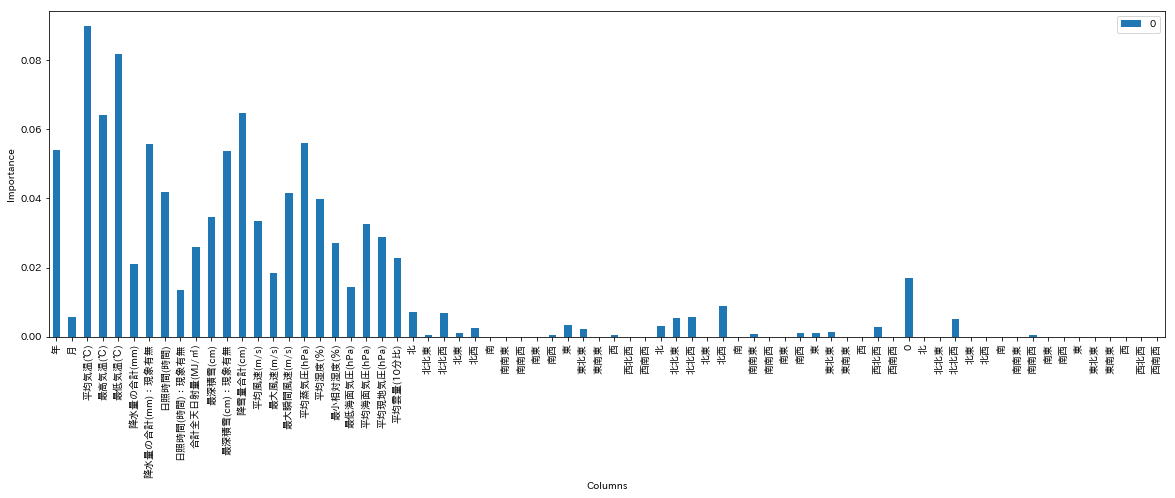

In [157]:
#ランダムフォレストを利用して特徴量の重要度を可視化する
clf =  RandomForestClassifier()
model = clf.fit(X_train, y_train)

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
fti = model.feature_importances_
print('Feature Importances:')
for i, feat in enumerate(df1):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))

print()
pd.DataFrame(clf.feature_importances_, index=X.columns).plot.bar(figsize=(20,6))
plt.ylabel("Importance")
plt.xlabel("Columns")
plt.show()

## 異常検知

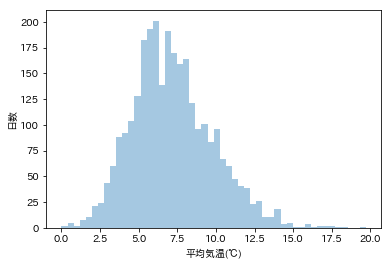

In [41]:
ax = sns.distplot(df["平均気温(℃)"], kde = False, bins = 50)
ax.set_ylabel("日数")
plt.show()

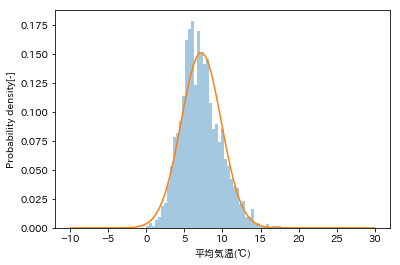

In [42]:
#パラメータの推定
muhat = df["平均気温(℃)"].mean()
sigmahat = df["平均気温(℃)"].std(ddof = 0)


ax = sns.distplot(df["平均気温(℃)"], kde=False, bins=50, norm_hist=True)
ax.set_ylabel("日数")
x = np.linspace(-10,30,100)
y = stats.norm.pdf(x, loc=muhat, scale=sigmahat)
plt.plot(x,y)
plt.ylabel("Probability density[-]")
plt.show()

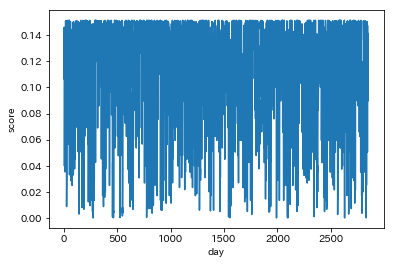

In [43]:
#確率密度の小ささを異常度に用いる
score = stats.norm.pdf(df["平均気温(℃)"], loc=muhat, scale=sigmahat)
plt.plot(score)
plt.xlabel("day")
plt.ylabel("score")
plt.show()

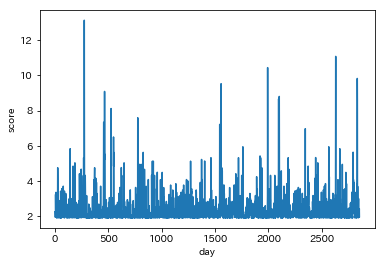

In [44]:
#情報量を異常度に用いる場合
score = stats.norm.pdf(df["平均気温(℃)"], loc = muhat, scale = sigmahat)
ascore = -np.log(score)
plt.plot(ascore)
plt.xlabel("day")
plt.ylabel("score")
plt.show()

In [45]:
#異常度が最大になる日を抜き出す
df.iloc[np.argmax(ascore),:]

年                  1990.0
月                    12.0
平均気温(℃)              19.7
最高気温(℃)              23.5
最低気温(℃)              17.0
降水量の合計(mm)            0.0
降水量の合計(mm)：現象有無       0.0
日照時間(時間)              9.3
日照時間(時間)：現象有無         0.0
合計全天日射量(MJ/㎡)        10.7
最深積雪(cm)              0.0
最深積雪(cm)：現象有無         1.0
降雪量合計(cm)             0.0
降雪量合計(cm)：現象有無        1.0
平均風速(m/s)             4.6
最大風速(m/s)            10.1
最大瞬間風速(m/s)          24.5
平均蒸気圧(hPa)           13.4
平均湿度(％)              58.0
最小相対湿度(％)            43.0
最低海面気圧(hPa)           0.0
平均海面気圧(hPa)         998.8
平均現地気圧(hPa)         994.7
平均雲量(10分比)            0.3
北                     0.0
北北東                   0.0
北北西                   0.0
北東                    0.0
北西                    0.0
南                     0.0
                    ...  
北東                    0.0
北西                    0.0
南                     0.0
南南東                   0.0
南南西                   1.0
南東                    0.0
南西                    0.0
東           

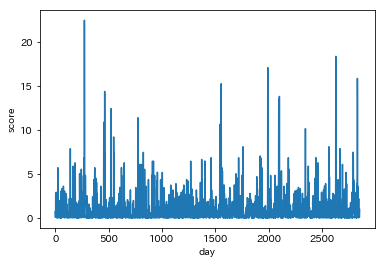

In [46]:
#ホテリングT2法
def calc_score(x,mu,sigma):
    return ((x-mu)/sigma)**2

ascore = calc_score(df["平均気温(℃)"], muhat, sigmahat)
plt.plot(ascore)
plt.xlabel("day")
plt.ylabel("score")
plt.show()

In [47]:
df["ascore"] = ascore
df.head()

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),...,南南西,南東,南西,東,東北東,東南東,西,西北西,西南西,ascore
0,1987,12,5.0,6.8,3.0,5.5,0,0.0,1,1.7,...,0,0,0,0,0,0,0,0,0,0.700910
1,1987,12,6.3,9.8,3.7,0.0,1,9.5,0,11.6,...,0,0,0,0,0,0,0,0,0,0.118013
2,1987,12,6.3,10.3,1.5,0.0,1,9.3,0,9.6,...,0,0,0,0,0,0,0,0,0,0.118013
3,1987,12,6.5,10.8,2.2,0.0,1,0.6,0,5.3,...,0,0,0,0,0,0,0,0,0,0.071600
4,1987,12,5.8,8.7,3.2,0.0,0,0.7,0,4.4,...,0,0,0,0,0,0,0,0,0,0.284521


In [48]:
#この異常道は、χ２乗分布にしたがうため、χ２乗分布で閾値を決める。
#5%の確率でしか起こらないものを異常と判定する
a_th = stats.chi2.ppf(0.95, df=1)
a_th

3.841458820694124

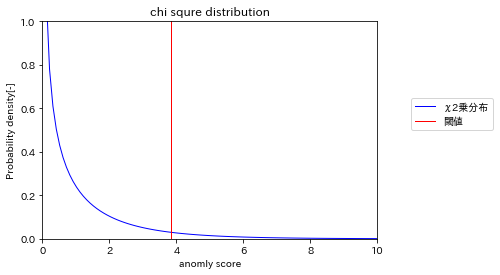

In [49]:
x = np.linspace(0.01, 10, 100)
fig, ax = plt.subplots(1,1)
ax.plot(x, stats.chi2.pdf(x,df=1),"b", lw=1, label="χ2乗分布")
ax.plot((a_th, a_th),(0,1),"r", lw=1, label="閾値")
ax.set_title("chi squre distribution")
ax.set_ylabel("Probability density[-]")
ax.set_ylim([0,1])
ax.set_xlim([0,10])
ax.legend(loc=(1.1,0.5))
ax.set_xlabel("anomly score")
plt.show()

In [50]:
df.sort_values("平均気温(℃)", ascending=True).head(5)

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),...,南南西,南東,南西,東,東北東,東南東,西,西北西,西南西,ascore
2793,2018,1,0.0,4.0,-4.0,0.0,1,9.6,0,14.20,...,0,0,0,0,0,0,0,0,0,7.485401
2442,2014,2,0.3,4.0,-0.9,29.5,0,0.0,0,1.49,...,0,0,0,0,0,0,0,0,0,6.874997
1402,2003,1,0.5,1.8,-0.6,16.5,0,0.0,1,2.10,...,0,0,0,0,0,0,0,0,0,6.482482
2794,2018,1,0.5,5.1,-3.1,0.0,1,8.3,0,12.66,...,0,0,0,0,0,0,0,0,0,6.482482
2692,2017,1,0.7,4.7,-2.3,0.0,1,8.1,0,11.60,...,0,0,0,0,0,0,0,1,0,6.101503


In [51]:
#閾値を超えるものの中で、平均気温が低いものからピックアップする
df_anormal = df[df["ascore"] > a_th]
df_anormal = df_anormal[df_anormal["平均気温(℃)"] < muhat]

In [52]:
df_anormal.sort_values("ascore", ascending = True)

,年,月,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),降水量の合計(mm)：現象有無,日照時間(時間),日照時間(時間)：現象有無,合計全天日射量(MJ/㎡),...,南南西,南東,南西,東,東北東,東南東,西,西北西,西南西,ascore
1710,2006,2,2.0,3.9,-0.1,0.0,0,0.6,0,4.80,...,0,0,0,0,0,0,0,0,0,3.906351
1231,2001,1,2.0,6.2,-0.8,0.0,1,8.8,0,11.40,...,0,0,0,0,0,0,0,0,0,3.906351
2534,2015,2,2.0,4.9,-0.6,0.0,1,1.7,0,5.97,...,0,0,0,0,0,0,0,0,0,3.906351
622,1994,2,2.0,5.2,-1.7,0.0,1,9.5,0,16.20,...,0,0,0,0,0,0,0,0,0,3.906351
2171,2011,2,2.0,5.5,0.8,11.0,0,0.0,0,1.85,...,0,0,0,0,0,0,0,0,0,3.906351
2801,2018,2,1.9,3.8,0.5,6.0,0,0.0,0,2.95,...,0,0,0,0,0,0,0,0,0,4.057904
1709,2006,2,1.9,6.7,-1.5,0.0,1,10.1,0,15.60,...,0,0,0,0,0,0,0,0,0,4.057904
955,1998,1,1.8,4.2,1.1,18.5,0,0.0,1,1.10,...,0,0,0,0,0,0,0,0,0,4.212341
1244,2001,1,1.8,4.5,0.5,33.0,0,0.0,1,0.80,...,0,0,0,0,0,0,0,0,0,4.212341
874,1997,1,1.7,4.9,-2.1,0.0,1,9.1,0,12.20,...,0,0,0,0,0,0,0,0,0,4.369662


In [53]:
df_anormal['降雪量合計(cm)：現象有無'].value_counts()
#150個中15個検出

0    18
1    15
Name: 降雪量合計(cm)：現象有無, dtype: int64

### 混合ガウス分布

In [54]:
clf = GaussianMixture()
clf.fit( df[df['降雪量合計(cm)：現象有無'].isin(["1"])])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

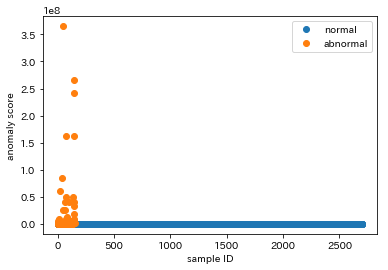

In [55]:
ascore_normal = -1 * clf.score_samples(df[df['降雪量合計(cm)：現象有無'].isin(["1"])])
ascore_abnormal = -1 * clf.score_samples(df[df['降雪量合計(cm)：現象有無'].isin(["0"])])

plt.plot(range(0,2703), ascore_normal, marker="o", ls="")
plt.plot(range(0,150), ascore_abnormal, marker="o", ls="")
plt.legend(["normal","abnormal"])
plt.xlabel("sample ID")
plt.ylabel("anomaly score")
plt.show()

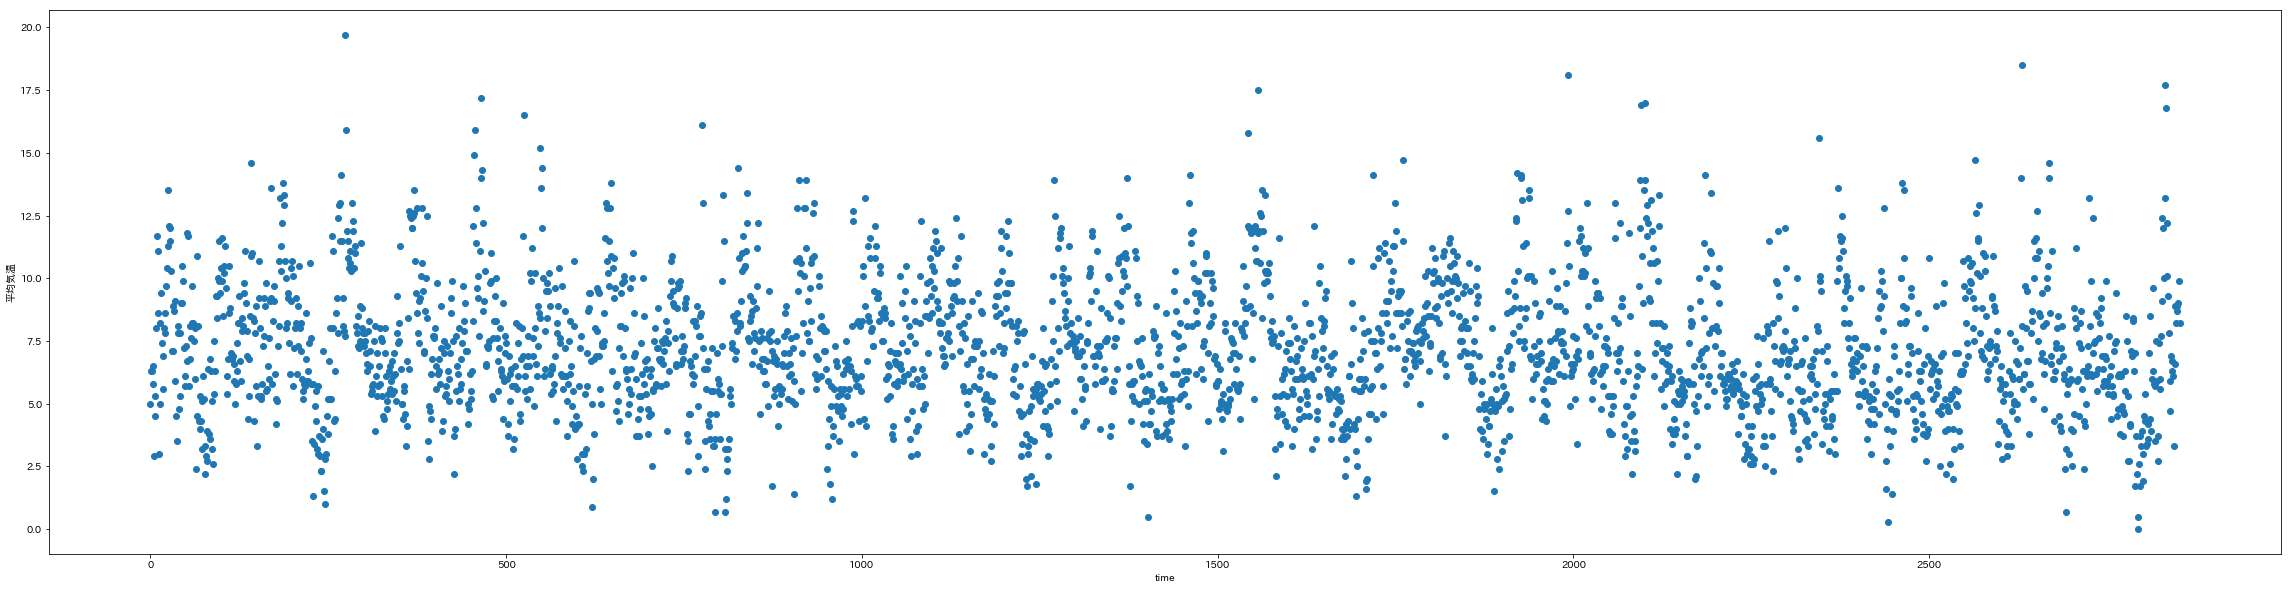

In [56]:
x = df.index
y = df["平均気温(℃)"]

plt.figure(figsize=(40,10))
plt.plot(x,y, marker="o", ls="")
plt.xlabel("time")
plt.ylabel("平均気温")
plt.show()

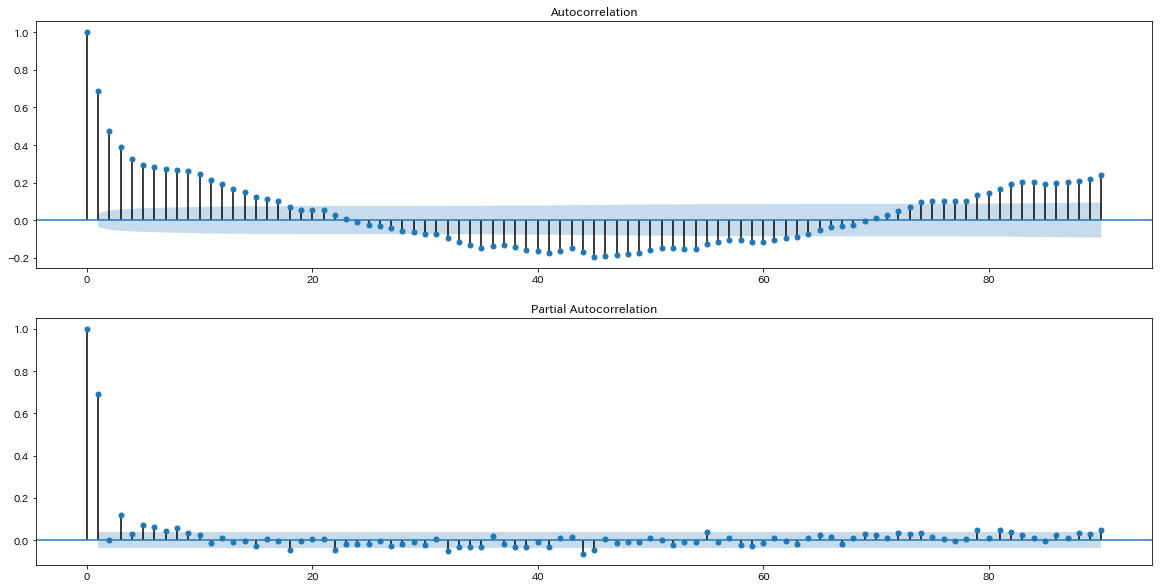

In [78]:
#fig, (ax1,ax2) = plt.subplots(nrows=2, sharex = True, figsize=(14,12)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(y, lags = 90, ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(y,lags = 90, ax=ax2)
plt.show()

In [92]:
ar = sm.tsa.AR(y)
model_ar = ar.fit(maxlag=10,method='cmle')
print(model_ar.params)

const          1.422312
L1.平均気温(℃)     0.671332
L2.平均気温(℃)    -0.086411
L3.平均気温(℃)     0.095426
L4.平均気温(℃)    -0.018867
L5.平均気温(℃)     0.023276
L6.平均気温(℃)     0.036327
L7.平均気温(℃)     0.001815
L8.平均気温(℃)     0.037354
L9.平均気温(℃)     0.020597
L10.平均気温(℃)    0.021830
dtype: float64


In [93]:
maxlag = 10
df_ar = pd.DataFrame(y)

# 部分時系列をつくる
for lag in range(1,maxlag+1):
    df_ar["x%s"%lag] = df_ar["平均気温(℃)"].shift(lag)
df_ar.head()

,平均気温(℃),x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.3,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.3,6.3,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.5,6.3,6.3,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.8,6.5,6.3,6.3,5.0,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# 最小二乗法
df_ar.dropna(inplace=True)
y_ = df_ar["平均気温(℃)"]
X = df_ar.drop(["平均気温(℃)"], axis=1)
X_hat = X - X.mean(axis=0)
y_hat = y_ - y_.mean(axis=0)
tmp = np.linalg.inv(np.dot(X_hat.T,X_hat))
tmp = np.dot(tmp, X_hat.T)
a = np.dot(tmp, y_hat)
a_0 = y_.mean() - np.dot(a.T,  X.mean())
print(a, a_0)

[ 0.67133248 -0.08641147  0.09542555 -0.01886672  0.0232755   0.03632675
  0.00181463  0.03735397  0.02059705  0.02182978] 1.422312226983622


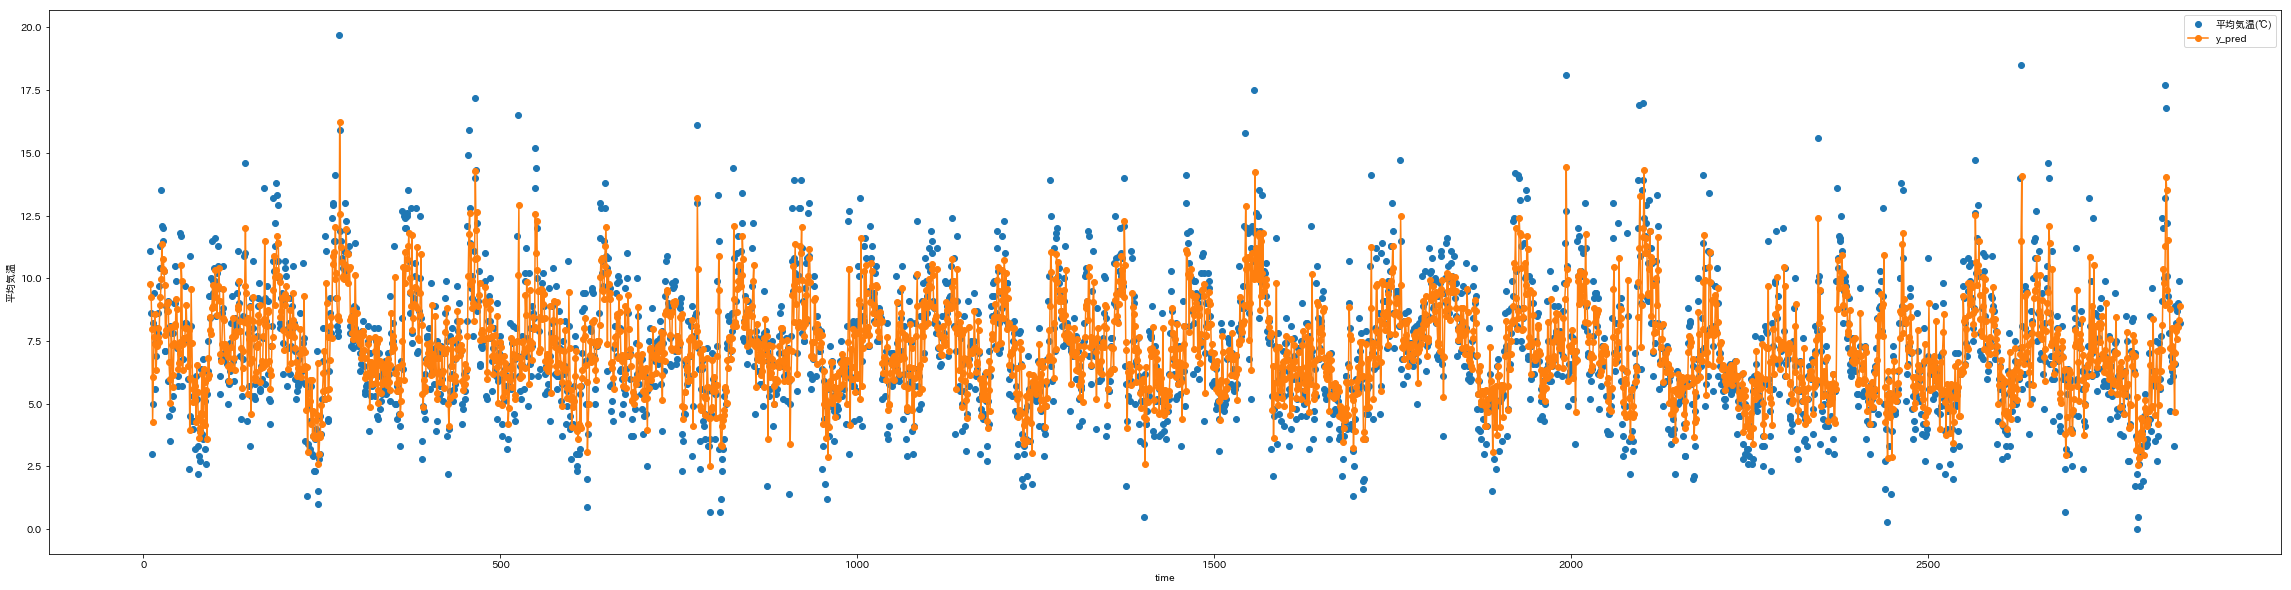

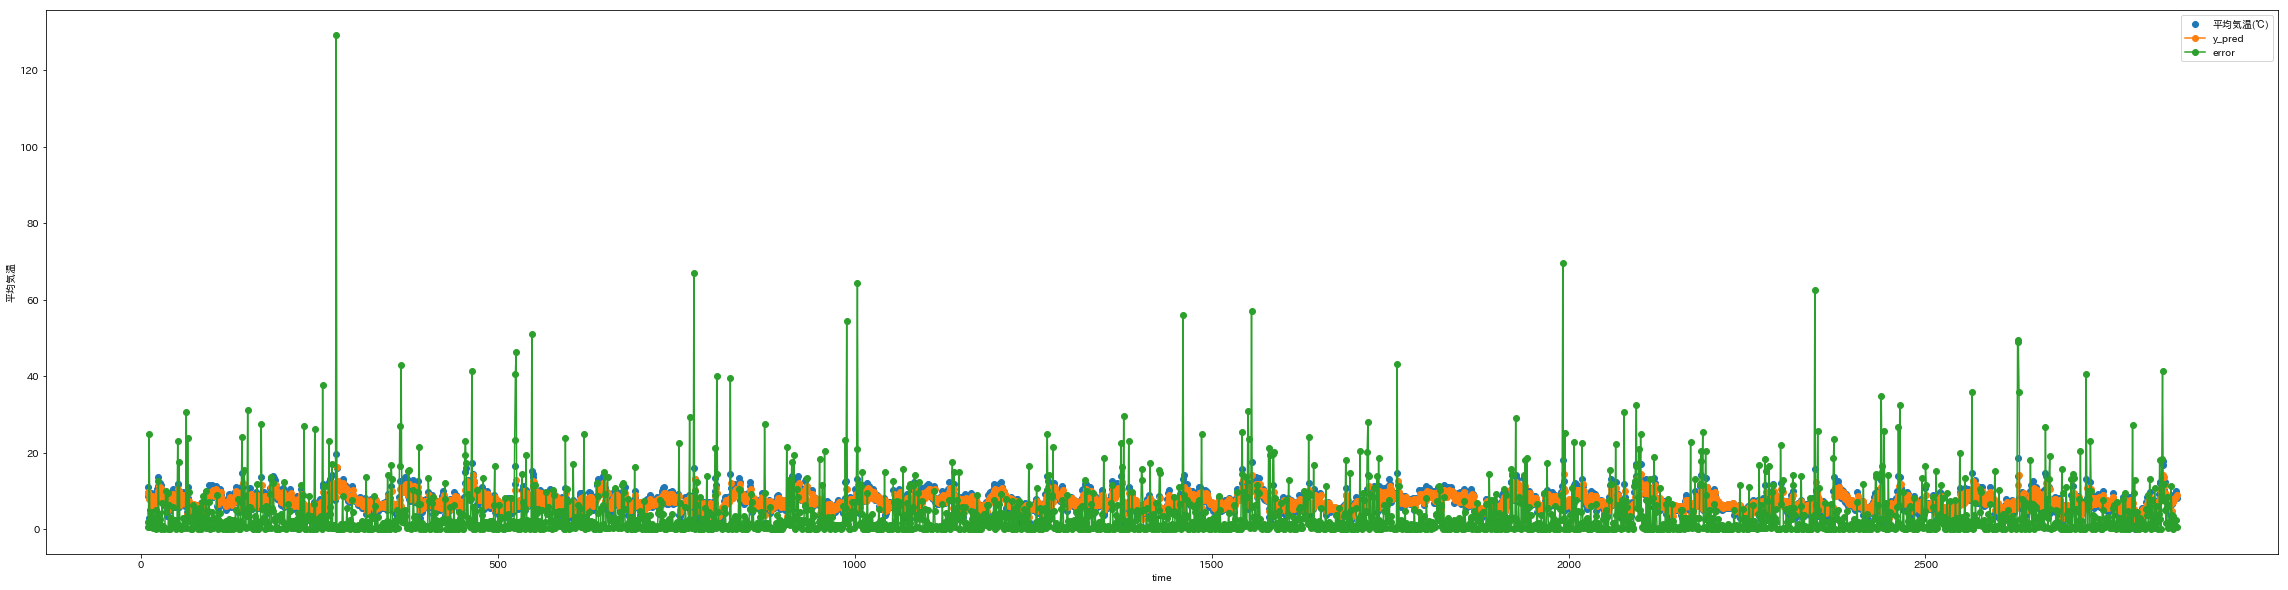

In [95]:
# 学習データを予測させる
y_pred = ar.predict(model_ar.params)
df_ar["y_pred"] = y_pred
df_ar["error"] = (df_ar["平均気温(℃)"] - df_ar["y_pred"])**2 #　誤差の2乗

# グラフ
plt.figure(figsize=(40,10))
df_ar["平均気温(℃)"].plot(marker="o", ls="")
df_ar["y_pred"].plot(marker="o", ls="-")
#df_ar["error"].plot(marker="o", ls="-")

plt.ylabel("平均気温")
plt.xlabel("time")
plt.legend(["平均気温(℃)", "y_pred","error"])

print()
plt.figure(figsize=(40,10))
df_ar["平均気温(℃)"].plot(marker="o", ls="")
df_ar["y_pred"].plot(marker="o", ls="-")
df_ar["error"].plot(marker="o", ls="-")

plt.ylabel("平均気温")
plt.xlabel("time")
plt.legend(["平均気温(℃)", "y_pred","error"])

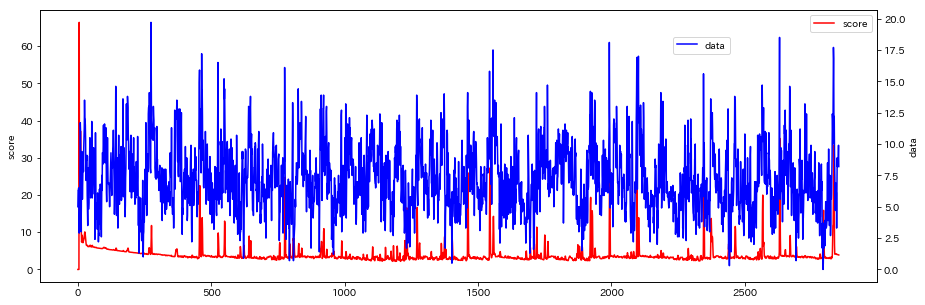

In [62]:
cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=3)

ret =[]
for i in df["平均気温(℃)"]:
    score = cf.update(i)
    ret.append(score)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
ax.plot(ret, "r")

ax2 = ax.twinx()
ax2.plot(df["平均気温(℃)"], "b")

ax.legend(["score"])
ax2.legend(["data"],bbox_to_anchor=(0.83,0.82))
ax.set_ylabel("score")
ax2.set_ylabel("data")
plt.show()

In [63]:
df_knn = pd.DataFrame(y).copy()

Text(0.5, 1.0, '正常Data')

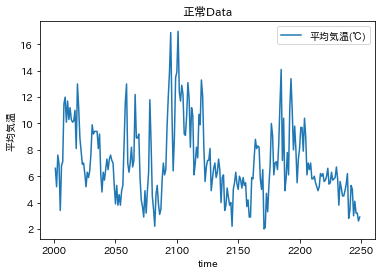

In [64]:
df_Dtr = df_knn.loc[(2000<df_knn.index)&(df_knn.index<2250),:].copy()
df_Dtr.plot()
plt.xlabel("time")
plt.ylabel("平均気温")
plt.title("正常Data")

Text(0.5, 1.0, '異常を含むかもしれないData')

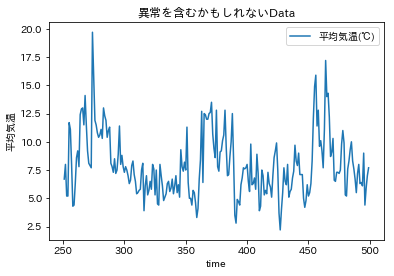

In [65]:
#異常を含むかもしれないデータ
df_D = df_knn.loc[(250<df_knn.index)&(df_knn.index<500),:].copy()
df_D.plot()
plt.xlabel("time")
plt.ylabel("平均気温")
plt.title("異常を含むかもしれないData")

In [66]:
# 窓幅を設定
window = 3

# 部分時系列に変換
for lag in range(1,window+1):
    df_Dtr["平均気温(℃)%s"%lag] = df_Dtr["平均気温(℃)"].shift(lag)
    df_D["平均気温(℃)%s"%lag] = df_D["平均気温(℃)"].shift(lag)

df_Dtr.dropna(inplace=True)    
df_D.dropna(inplace=True)    

print("Dtrの部分時系列集合")
display(df_Dtr.head())
print("Dの部分時系列集合")
display(df_D.head())

Dtrの部分時系列集合


,平均気温(℃),平均気温(℃)1,平均気温(℃)2,平均気温(℃)3
2004,6.9,7.6,5.2,6.6
2005,3.4,6.9,7.6,5.2
2006,6.8,3.4,6.9,7.6
2007,7.1,6.8,3.4,6.9
2008,11.5,7.1,6.8,3.4


Dの部分時系列集合


,平均気温(℃),平均気温(℃)1,平均気温(℃)2,平均気温(℃)3
254,5.2,5.2,8.0,6.7
255,11.7,5.2,5.2,8.0
256,11.1,11.7,5.2,5.2
257,8.0,11.1,11.7,5.2
258,4.3,8.0,11.1,11.7


In [67]:
def dist(Dtr, x):
    """
    距離を測る関数
    """
    return np.linalg.norm(Dtr - x, axis=1)

def score(k, d):
    """
    異常度を算出する関数
    """
    # dの小さい方からk個選ぶ
    d = np.sort(d)[:k]
    return np.mean(d)
    
k = 5
Dtr = df_Dtr.values
D = df_D.values
    
li_ascore = []
for i in range(D.shape[0]):
    x = D[i,:]
    
    # 距離の算出
    d = dist(Dtr, x)
    
    # 異常度の算出
    ascore = score(k, d)
    li_ascore.append(ascore)

Text(0.5, 1.0, '近傍法による異常検知')

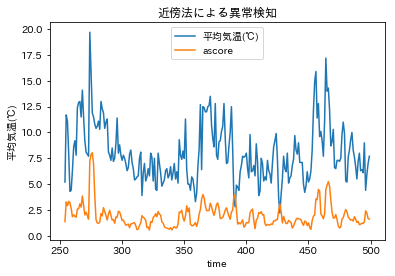

In [68]:
df_result = df_D[["平均気温(℃)"]].copy()
df_result["ascore"] = li_ascore
df_result.plot()

plt.xlabel("time")
plt.ylabel("平均気温(℃)")
plt.title("近傍法による異常検知")

In [69]:
df_subspace = pd.DataFrame(y).copy()

Text(0.5, 1.0, '正常Data')

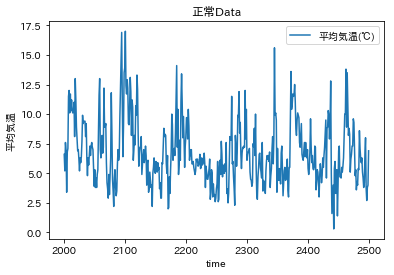

In [105]:
df_Dtr = df_subspace.loc[(2000<df_subspace.index)&(df_subspace.index<2500),:].copy()
df_Dtr.plot()
plt.xlabel("time")
plt.ylabel("平均気温")
plt.title("正常Data")

Text(0.5, 1.0, '異常を含むかもしれないData')

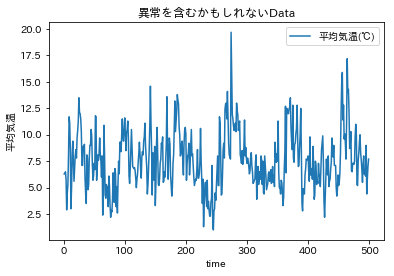

In [106]:
#異常を含むかもしれないデータ
df_D = df_subspace.loc[(0<df_subspace.index)&(df_subspace.index<500),:].copy()
df_D.plot()
plt.xlabel("time")
plt.ylabel("平均気温")
plt.title("異常を含むかもしれないData")

In [113]:
# 窓幅を設定
w=90

# 履歴行列およびテスト行列の列数を設定
k=w//2 # 任意の値でもよい

# 履歴行列とテスト行列のラグ(ズレの数)を設定
L=k//2 # 任意の値でもよい

# 部分時系列を求める
df_sub = df_D.copy()
for i in range(1,w):
    df_sub["平均気温(℃)%s"%i] = df_sub["平均気温(℃)"].shift(-1*i) # 将来の値を列方向に並べていることに注意
df_sub.dropna(inplace=True)
print(df_sub.shape)

(410, 90)


In [114]:
import numpy.linalg as LA
# 左特異ベクトルの本数
m = 2

# 時系列の長さ
T = len(df_sub)

li_cscore = []
for t in range(T):

    # 履歴行列をつくる
    sta = t - k - w
    end = t - w
    if sta<0:
        li_cscore.append(0)
        continue
    else:
        X1 = df_sub.iloc[sta:end].values.T

    # テスト行列をつくる
    sta = t - k - w + L 
    end = t - w + L
    if sta<0 or end<0 or T<end :
        li_cscore.append(0)
        continue
    else:
        X2 = df_sub.iloc[sta:end].values.T

    # 履歴行列を特異値分解
    Um, _, _ = LA.svd(X1)
    Um = Um[:,:m]

    # テスト行列を特異値分解
    Qm, _, _ = LA.svd(X2)
    Qm = Qm[:,:m]
    
    # 変化度を求める
    UmQm = np.dot(Um.T,Qm)
    _, s, _ = LA.svd(UmQm)
    max_sing = s[0] #最大特異値

    cscore = 1 -  max_sing**2    
    print("max_sing=",max_sing, "cscore=",cscore)
    
    if cscore>1*10e-5:
        print("anomaly")
    
    li_cscore.append(cscore)

max_sing= 0.9997817382704761 cscore= 0.00043647582086514536
anomaly
max_sing= 0.9997902214196817 cscore= 0.00041951315358390584
anomaly
max_sing= 0.9998008186839703 cscore= 0.00039832295886277347
anomaly
max_sing= 0.9998108233537516 cscore= 0.00037831750469330405
anomaly
max_sing= 0.9998128530521907 cscore= 0.0003742588716385553
anomaly
max_sing= 0.9998021709443505 cscore= 0.00039561897496365184
anomaly
max_sing= 0.9997825248899886 cscore= 0.0004349029245992453
anomaly
max_sing= 0.9997672416078686 cscore= 0.00046546260779378734
anomaly
max_sing= 0.9997781634186664 cscore= 0.0004436239511983464
anomaly
max_sing= 0.999804930024644 cscore= 0.00039010189841670595
anomaly
max_sing= 0.9998171692751054 cscore= 0.0003656280227151143
anomaly
max_sing= 0.9998092370968831 cscore= 0.00038148941574867035
anomaly
max_sing= 0.9997611084933966 cscore= 0.0004777259440548187
anomaly
max_sing= 0.9996433472081089 cscore= 0.0007131783825682358
anomaly
max_sing= 0.9994482575138421 cscore= 0.0011031805525446

max_sing= 0.9990824351416338 cscore= 0.0018342877914632183
anomaly
max_sing= 0.999037673243699 cscore= 0.0019237274398161697
anomaly
max_sing= 0.9989420059102533 cscore= 0.0021148688279994943
anomaly
max_sing= 0.998828646544514 cscore= 0.0023413348420543434
anomaly
max_sing= 0.9987476248419778 cscore= 0.0025031818725080868
anomaly
max_sing= 0.9987580533184635 cscore= 0.0024823509315132775
anomaly
max_sing= 0.9988429304827996 cscore= 0.0023128002245331736
anomaly
max_sing= 0.9989290107850084 cscore= 0.002140831412084543
anomaly
max_sing= 0.99896588432695 cscore= 0.002067161950874752
anomaly
max_sing= 0.9989703667043537 cscore= 0.0020582064465691774
anomaly
max_sing= 0.9990152861837239 cscore= 0.0019684579712522243
anomaly
max_sing= 0.9990497061712097 cscore= 0.00189968459921952
anomaly
max_sing= 0.999086682016837 cscore= 0.0018258018165875356
anomaly
max_sing= 0.9991292203375403 cscore= 0.001740801067698916
anomaly
max_sing= 0.9991688723401586 cscore= 0.0016615645464957973
anomaly
max_s

max_sing= 0.9991031220302103 cscore= 0.0017929515494866655
anomaly
max_sing= 0.9991676831861026 cscore= 0.0016639408765161123
anomaly
max_sing= 0.9992089958860254 cscore= 0.0015813825404408233
anomaly
max_sing= 0.9992366671285943 cscore= 0.0015260830657388702
anomaly
max_sing= 0.999248155584603 cscore= 0.001503123560768982
anomaly
max_sing= 0.9992458435022196 cscore= 0.001507744243537723
anomaly
max_sing= 0.9992251174610234 cscore= 0.0015491646350039856
anomaly
max_sing= 0.999187773550675 cscore= 0.001623793186845024
anomaly
max_sing= 0.9991447780823632 cscore= 0.0017097124307451361
anomaly
max_sing= 0.9991022718074578 cscore= 0.0017946504691767062
anomaly
max_sing= 0.9990595989875898 cscore= 0.001879917670756348
anomaly
max_sing= 0.9990206489147655 cscore= 0.0019577430419208675
anomaly
max_sing= 0.9989915688025464 cscore= 0.0020158454614273014
anomaly
max_sing= 0.9989652279565754 cscore= 0.002068473333667331
anomaly
max_sing= 0.9989536532988905 cscore= 0.00209159856079999
anomaly
max_

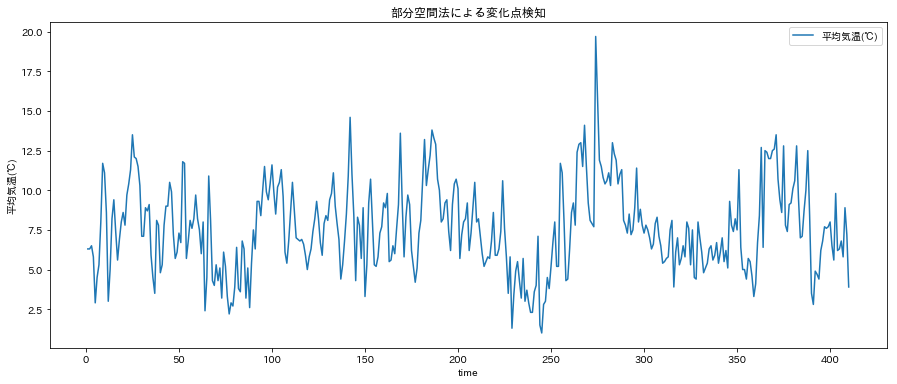

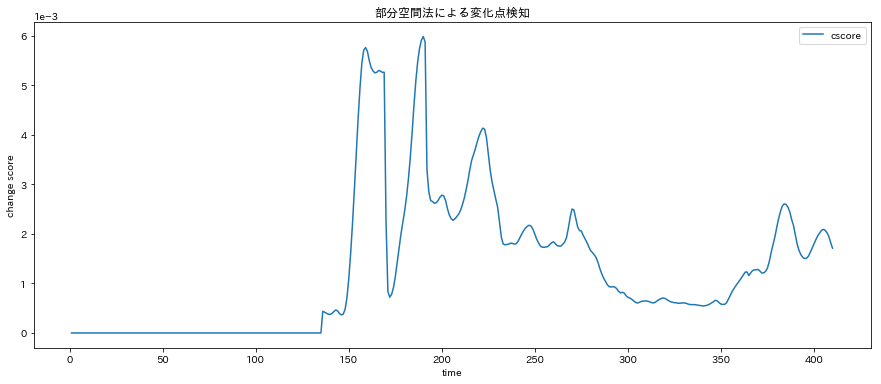

In [115]:
df_result = df_sub[["平均気温(℃)"]].copy()
df_result["cscore"] = li_cscore
df_result[["平均気温(℃)"]].plot(figsize=(15,6))
plt.xlabel("time")
plt.ylabel("平均気温(℃)")
plt.title("部分空間法による変化点検知")
plt.show()

df_result[["cscore"]].plot(figsize=(15,6))
plt.xlabel("time")
plt.ylabel("change score")
plt.title("部分空間法による変化点検知")
plt.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
plt.show()

### 反省

#### good point
- 基本的な機械学習と異常検知の違いを知れた
- 事前に統計学検定2級の講座を受けて、異常検知モデルの理解の助けとなった
- 数式に突っ込んだ講義で、分かりやすいでした
- 時系列系のアルゴリズムに絞ったため、時系列データの取扱について改めて考えるきっかけになった。
- 思い切って冬の季節のデータに絞って、計算効率と学習も向上した
- 基本的な機械学習モデルが最終的にスコアがよくなった。
- 他の参加者のNotebookをみるとPandasの使い方や関数の設定の仕方が非常に参考になった（ものすごいレベル差を感じる）

#### 発展課題
- 閾値の設定と性能評価までできていないので、そこまでいって、ROCを上げるような工夫
- ハイパーパラメータのチューニングが図をみて適当にやっている部分もあるため（部分空間法など）、改善余地がある
- 期間内に雪による電車及び飛行機の運休履歴データを探し当てられなかった。もし発見できれば説明変数に割り当てたい
- 降雪と雨における雲の状態は同じで、気温による溶け具合で分かれるという記事をみた。今回冬のみに絞ったが、春夏秋でも雨のデータを学習することでより制度のよいモデルが作れるかも知れない
- ２次元データしか扱ってないため、高次元データを扱えるように
- 全体的に数式の理解と実装力が進んでいないため、改めてスライドを見直すことに加えて基礎数学
- 時系列データに関して全結合NNやLSTMも行ってみたい

時系列の事前のデータを利用して、雪の日を検知する
時系列データを区切ると不連続になるので、時系列でなく一括したデータにしたほうがい
予知での工夫が必要